The purpose of this notebook is to summarize and graph findings.

In [1]:
import pickle
import math
import json
import numpy as np
import matplotlib.pyplot as plt

CUNAME = 'Columbia University in the City of New York'

S_TOTALS = pickle.load(open('../data/S_Sex_Graduates.p', 'rb'))
E_TOTALS = pickle.load(open('../data/E_Sex_Graduates.p', 'rb'))
D_TOTALS = pickle.load(open('../data/SE-Detailed_Sex.p', 'rb'))

years = sorted(S_TOTALS.keys())
institutions = sorted(S_TOTALS[ max(years) ].keys())
fields = {
    'Science': set(),
    'Engineering': set()
}
topic_lookup = {}
for year in years:
    inst_stats = D_TOTALS[year]['Columbia University in the City of New York']
    for topic in inst_stats.keys():
        for field in inst_stats[topic].keys():
            fields[topic].add(field)
            topic_lookup[field] = topic
fields['Science'] = sorted(fields['Science'])
fields['Engineering'] = sorted(fields['Engineering'])

ORIGINAL_BROADS = {
    'Biological sciences': ['Anatomy', 'Biochemistry', 'Biology', 'Biometry and epidemiology', 'Biophysics',
                            'Biosciences not elsewhere classified', 'Cell and molecular biology', 'Ecology',
                            'Genetics', 'Microbiology, immunology, and virology', 'Nutrition', 'Pathology',
                            'Pharmacology and toxicology', 'Physiology'],
    'Computer sciences': ['Computer sciences'],
    'Engineering': ['Biomedical engineering', 'Chemical engineering', 'Civil engineering',
                    'Electrical engineering', 'Engineering not elsewhere classified',
                    'Engineering science, mechanics, and physics', 'Industrial and manufacturing engineering',
                    'Mechanical engineering', 'Mining engineering'],
    'Earth, atmospheric, and ocean sciences': ['Earth, atmospheric, and ocean sciences not elsewhere classified',
                                               'Geosciences'],
    'Mathematics and statistics': ['Mathematics and applied mathematics', 'Statistics'],
    'Neurobiology and neuroscience': ['Neurobiology and neuroscience'],
    'Physical sciences': ['Astronomy and astrophysics', 'Chemistry', 'Physics'],
    'Psychology': ['Psychology, general'],
    'Social sciences': ['Anthropology', 'Economics (except agricultural)', 'Linguistics',
                        'Political science and government', 'Social sciences not elsewhere classified',
                        'Sociology'],
}

sparse_fields = ['Anatomy', 'Cell and molecular biology', 'Ecology', 'Linguistics', 
                 'Neurobiology and neuroscience', 'Pathology', 'Chemical engineering',
                 'Engineering not elsewhere classified', 'Mining engineering']
BROADS = {}

for broad_name in ORIGINAL_BROADS.keys():
    broad_fields = [f for f in ORIGINAL_BROADS[broad_name] if f not in sparse_fields]
    if len(broad_fields) > 0:
        BROADS[broad_name] = broad_fields

print('This should be True:')
print(
    sum([len(v) for v in BROADS.values()]) ==
    len(fields['Science'] + fields['Engineering']) - len(sparse_fields)
)

This should be True:
True


In [2]:
def get_props(inst):
    females = sum_a(
        [S_TOTALS[year][inst]['Female'] for year in years],
        [E_TOTALS[year][inst]['Female'] for year in years],
    )
    males = sum_a(
        [S_TOTALS[year][inst]['Male'] for year in years],
        [E_TOTALS[year][inst]['Male'] for year in years],
    )
    return [f / (m+f) for f, m in zip(females, males)]

def plot_inst_props(ax):
    for inst in institutions:
        if inst != CUNAME:
            ax.plot(years, get_props(inst), label=inst)
    ax.plot(years, get_total_proportions(), linewidth=3, color='black')
    ax.set_ylim(bottom=0, top=1)
    ax.legend()

In [26]:
# Convenient function for making subplots
def subplots(num=1, cols=3, figsize=6):
    if num < cols:
        cols = num
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))

# Gets female and male headcounts for a field in an institution
def get_counts(field, inst=CUNAME, zero_beginnings=False):
    females = []
    males = []
    topic = topic_lookup[field]
    for year in years:
        stats = D_TOTALS[year][inst][topic].get(field, None)
        if stats is None:
            females.append(None)
            males.append(None)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    
    """
    EXTREMELY HACKY IMPUTATION METHOD: Many fields were not reported between 2001 and 2003,
    but only Psychology was not reported bewtween 2000. We will do a carry-forward
    imputation for only this field for only 2000.
    """
    if field == 'Psychology, general' and zero_beginnings:
        females[2000 - years[0]] = females[1999 - years[0]]
        males[2000 - years[0]] = males[1999 - years[0]]
    
    if zero_beginnings:
        i = 0
        while i < len(females) and females[i] is None and males[i] is None:
            females[i] = 0
            males[i] = 0
            i += 1
    return females, males

# Gets proportions for a field
def get_proportions(field, inst=CUNAME):
    females, males = get_counts(field, inst, zero_beginnings=True)
    proportions = []
    for i in range(len(years)):
        f, m = females[i], males[i]
        if f is None or m is None: 
            proportions.append(None)
        else:
            proportions.append(None if m+f == 0 else f / (m+f))
    return proportions

# Get net percent change in a field
def get_field_growth(field):
    females, males = get_counts(field)
    start_i = 0
    last_i = -1
    for k in range(len(females)):
        if females[k] is not None:
            start_i = k
            break
    for k in range(len(females) - 1, -1, -1):
        if females[k] is not None:
            last_i = k
            break
    return (females[last_i] + males[last_i] - females[start_i] - males[start_i]) / (
        females[start_i] + males[start_i]
    )

# Get field growths for a list of fields
def get_field_growths(fields):
    return list(zip(fields, [get_field_growth(f) for f in fields]))

# Gets total populations for a field
def get_total_counts(field, inst=CUNAME):
    females, males = get_counts(field, inst)
    return [f + m for f, m in zip(females, males)]

# Sets commonly used elements on an axis
x_ticks = [1994 + 4*i for i in range(6)]
def set_defaults(ax):
    ax.set_xticks(x_ticks)
    ax.grid()
    ax.set_ylim(bottom=0)
    ax.set_xticks(x_ticks)

# Plots proportions for a field
def plot_proportions(ax, field, inst=CUNAME, title=None, peers=False,
                     start=1994, label_line=False):
    proportions = get_proportions(field, inst)
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_proportions(field, inst), color='lightgreen', linewidth=1)
    start_i = start - years[0]
    # ax.plot(years[:start_i + 1], proportions[:start_i + 1], color='lightgreen')
    ax.plot(years[start_i:], proportions[start_i:], color='green')
    
    set_defaults(ax)
    if label_line: ax.annotate(field, (years[start_i], proportions[start_i]))
    ax.set_ylim(top=1)
    ax.set_title(title or field)

# Plots female and male headcounts for a field
def plot_counts(ax, field, inst=CUNAME, title=None, show_pcts=False):
    females, males = get_counts(field, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')

    set_defaults(ax)    
    ax.set_xlim(left=years[0], right=years[-1])
    ax.set_ylabel('Number of people')
    ax.legend()
    
    default_title = field
    if show_pcts:
        default_title += ' {0:.0%}'.format(get_field_growth(field))
    ax.set_title(title or default_title)

# Plots proportions and counts for a field
def plot_pair(ax_ary, index, field, inst=CUNAME):    
    if index == None:
        axs = [ax_ary[i] for i in range(2)]
    else:
        axs = [ax_ary[index, i] for i in range(2)]
    plot_proportions(axs[0], field, inst, peers=True)
    plot_counts(axs[1], field, inst)

# Plots pairs for multiple fields
def plot_fields_pairs(selected_fields, inst=CUNAME):
    num_fields = len(selected_fields)
    _, ax = subplots(num_fields*2, cols=2)
    if num_fields == 1:
        plot_pair(ax, None, selected_fields[0], inst)
        return
    for i, field in enumerate(selected_fields):
        plot_pair(ax, i, field, inst)

# Gets overall counts from complete fields for an institution in a topic
def get_overall_counts(topic, inst=CUNAME):
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts(field, inst) for field in complete_fields[topic]}

    for field in complete_fields[topic]:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i] or 0
            overallM[i] += m[i] or 0 # THESE DEFAULT VALUES ARE TEMPORARY. REMOVE AFTER COMPLETE IMPUTATION
    return overallF, overallM

# Gets overall proportions from overall counts
def get_overall_proportions(topic, inst=CUNAME):
    overallF, overallM = get_overall_counts(topic, inst)
    return [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)]

# Plots proportions for a topic
def plot_topic_proportions(ax, topic, peers=False, title=None, label=[]):
    colors = ['blue', 'lightblue']
    if topic == 'Science':
        colors = ['red', 'pink']
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_overall_proportions(topic, inst), color=colors[1], linewidth=1)
    cu_props = get_overall_proportions(topic, CUNAME)
    ax.plot(years, cu_props, color=colors[0], linewidth=2)
    for i in [0, -1] + [year - years[0] for year in label]:
        ax.annotate("{0:.0%}".format(cu_props[i]), (years[i], cu_props[i]))
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or topic)

# Plots a female and male headcounts for a topic
def plot_topic_counts(ax, topic, inst=CUNAME, title=None):
    females, males = get_overall_counts(topic, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(title or topic)
    ax.set_ylabel('Number of people')

# Plots counts for a list of fields
def plot_fields_counts(selected, num_cols=4, show_pcts=False, inst=CUNAME):
    num_fields = len(selected)
    _, ax_arr = subplots(num_fields, cols=num_cols)
    for i, field in enumerate(selected):
        if math.ceil(num_fields / num_cols) == 1:
            if num_fields == 1:
                plot_counts(ax_arr, field, show_pcts=show_pcts, inst=inst)
            else:
                plot_counts(ax_arr[i], field, show_pcts=show_pcts, inst=inst)
        else:
            plot_counts(ax_arr[i // num_cols, i % num_cols], field, show_pcts=show_pcts, inst=inst)

# Gets total counts for a broad field
def get_broad_counts(broad_name, inst=CUNAME):
    females = [0 for _ in range(len(years))]
    males = [0 for _ in range(len(years))]

    for field in BROADS[broad_name]:
        field_females, field_males = get_counts(field, inst, zero_beginnings=True)
        for i in range(len(years)):
            f, m = field_females[i], field_males[i]
            if females[i] is None or males[i] is None:
                continue
            if f is None or m is None:
                females[i], males[i] = None, None
            else:
                females[i] += f
                males[i] += m
    return females, males

# Gets broad field proportions
def get_broad_proportions(broad_name, inst=CUNAME):
    females, males = get_broad_counts(broad_name, inst)
    props = []
    for f, m in zip(females, males):
        if f is None or m is None or (f == 0 and m == 0):
            props.append(None)
        else:
            props.append(f / (m + f))
    return props

# Plots proportions for a broad field
def plot_broad_proportions(ax, broad_name, inst=CUNAME, title=None, peers=False):
    proportions = get_broad_proportions(broad_name, inst)
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_broad_proportions(broad_name, inst), color='lightpink', linewidth=1)
    ax.plot(years, proportions, color='red')
    
    set_defaults(ax)
    ax.set_ylim(top=1)
    ax.set_title(title or broad_name)

# Plots female and male headcounts for a field
def plot_broad_counts(ax, broad_name, inst=CUNAME, title=None):
    females, males = get_broad_counts(broad_name, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')

    set_defaults(ax)    
    ax.set_xlim(left=years[0], right=years[-1])
    ax.set_ylabel('Number of people')
    ax.legend()

    ax.set_title(title or broad_name)

# Plots proportions and counts for a broad field
def plot_broad_pair(ax_ary, index, broad_name):    
    if index == None:
        axs = [ax_ary[i] for i in range(2)]
    else:
        axs = [ax_ary[index, i] for i in range(2)]
    plot_broad_proportions(axs[0], broad_name, peers=True)
    plot_broad_counts(axs[1], broad_name)

# Plots pairs for multiple broad fields
def plot_broads_pairs(broads):
    num_broads = len(broads)
    _, ax = subplots(num_broads*2, cols=2)
    if num_broads == 1:
        plot_broad_pair(ax, None, broads[0])
        return
    for i, broad_name in enumerate(broads):
        plot_broad_pair(ax, i, broad_name)

# Plots counts for all institutions for a field
def plot_counts_insts(field):
    num_cols = 4
    _, ax_arr = subplots(len(institutions), cols=num_cols)
    for i in range(len(institutions)):
        plot_counts(ax_arr[i // num_cols, i % num_cols], field, institutions[i], title=institutions[i])

# Plots counts for all institutions for a broad field
def plot_broad_counts_insts(broad):
    num_cols = 4
    _, ax_arr = subplots(len(institutions), cols=num_cols)
    for i in range(len(institutions)):
        plot_broad_counts(ax_arr[i // num_cols, i % num_cols], broad, institutions[i], title=institutions[i])

# Plots proportions for all institutions for a broad field
def plot_broad_proportions_insts(broad):
    num_cols = 4
    _, ax_arr = subplots(len(institutions), cols=num_cols)
    for i in range(len(institutions)):
        plot_broad_proportions(ax_arr[i // num_cols, i % num_cols], broad, institutions[i], title=institutions[i])

def sum_a(x, y):
    result = []
    for i in range(len(x)):
        if x[i] is None or y[i] is None:
            result.append(None)
        else:
            result.append(x[i] + y[i])
    return result

# Gets counts for all fields
def get_total_counts(inst=CUNAME):
    females = [0 for _ in range(len(years))]
    males = [0 for _ in range(len(years))]

    for broad in BROADS.keys():
        fs, ms = get_broad_counts(broad, inst)
        females = sum_a(females, fs)
        males = sum_a(males, ms)
    return females, males

# Gets proportions for all fields
def get_total_proportions(inst=CUNAME):
    females, males = get_total_counts(inst)
    props = [None if f is None else f / (m+f) for f, m in zip(females, males)]
    return props

# Plots total proportions
def plot_total_proportions(ax):
    for inst in institutions:
        if inst != CUNAME:
            ax.plot(years, get_total_proportions(inst), label=inst)
    ax.plot(years, get_total_proportions(), linewidth=3, color='purple')
    ax.legend()
    
    set_defaults(ax)
    ax.set_ylim(top=1)
    ax.set_title('Proportions in all fields')

# Plots total female and male headcounts
def plot_total_counts(ax):
    females, males = get_total_counts()
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')

    set_defaults(ax)    
    ax.set_xlim(left=years[0], right=years[-1])
    ax.set_ylabel('Number of people')
    ax.legend()

    ax.set_title('Counts in all fields')

def plot_connected(ax, counts):
    females, males = counts
    ax.plot(females, males, color='lightgray')
    ax.scatter(females, males, c=[i for i in range(len(males))], cmap='viridis')
    for i in [0, -1]: # range(len(years)):
        if females[i] is not None:
            ax.annotate(years[i], (females[i], males[i]))
    _, ymax = ax.get_ylim()
    _, xmax = ax.get_xlim()
    top = max(ymax, xmax)    
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(left=0, right=top)
    ax.plot([0, top], [0, top], color='gray', linestyle='--')
    ax.set_xlabel('Number of women')
    ax.set_ylabel('Number of men')

def plot_triplet(name=None):
    _, ax = subplots(3)
    if name is None: # totals
        plot_total_proportions(ax[0])
        plot_total_counts(ax[1])
        plot_connected(ax[2], get_total_counts())
    elif name in BROADS.keys(): # broad field
        plot_broad_proportions(ax[0], name)
        plot_broad_counts(ax[1], name)
        plot_connected(ax[2], get_broad_counts(name))
    else: # regular field
        plot_proportions(ax[0], name)
        plot_counts(ax[1], name)
        plot_connected(ax[2], get_broad_counts(name)) 

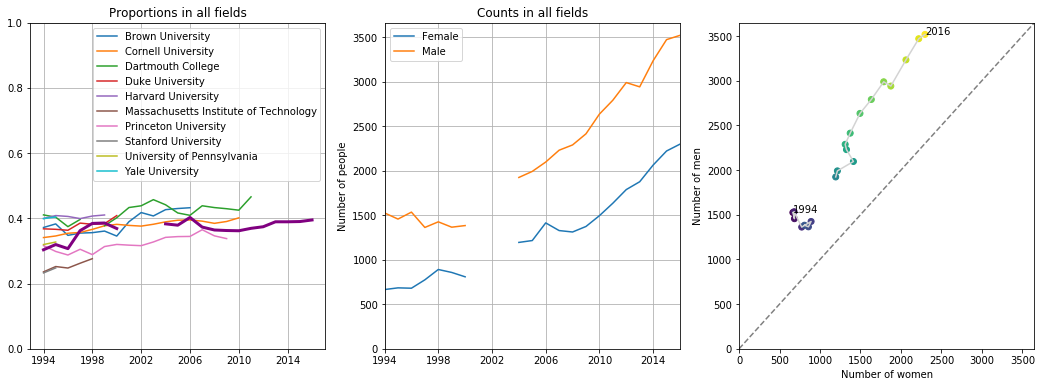

In [24]:
plot_triplet()

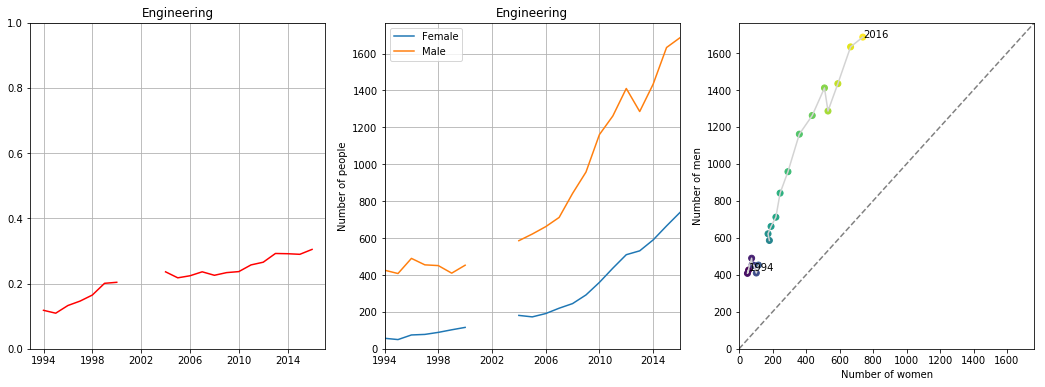

In [25]:
plot_triplet('Engineering')

In [16]:
def merge_counts(counts):
    females, males = counts
    pairs = []
    for i in range(len(years)):
        f, m = females[i], males[i]
        if f is not None and m is not None:
            pairs.append([int(f), int(m)])
        else:
            pairs.append([f, m])
    return pairs

data = {
    'TOTALS': merge_counts(get_total_counts()),
    'Engineering': { CUNAME: merge_counts(get_broad_counts('Engineering')) },
    'Statistics': { CUNAME: merge_counts(get_counts('Statistics')) },
    'Civil engineering': { CUNAME: merge_counts(get_counts('Civil engineering')) },
    'Mechanical engineering': { CUNAME: merge_counts(get_counts('Mechanical engineering')) },
}

with open('../../graduate-diversity/src/data.js', 'w') as out:
    json_str = json.dumps(data)
    out.write(f'export default {json_str};');

# All fields

Notes: Because the sciences are spread out over so many schools, we will just have to adopt this method: Holes in data before the start and after the end will be zero-ed. Anything in between will be remain empty.

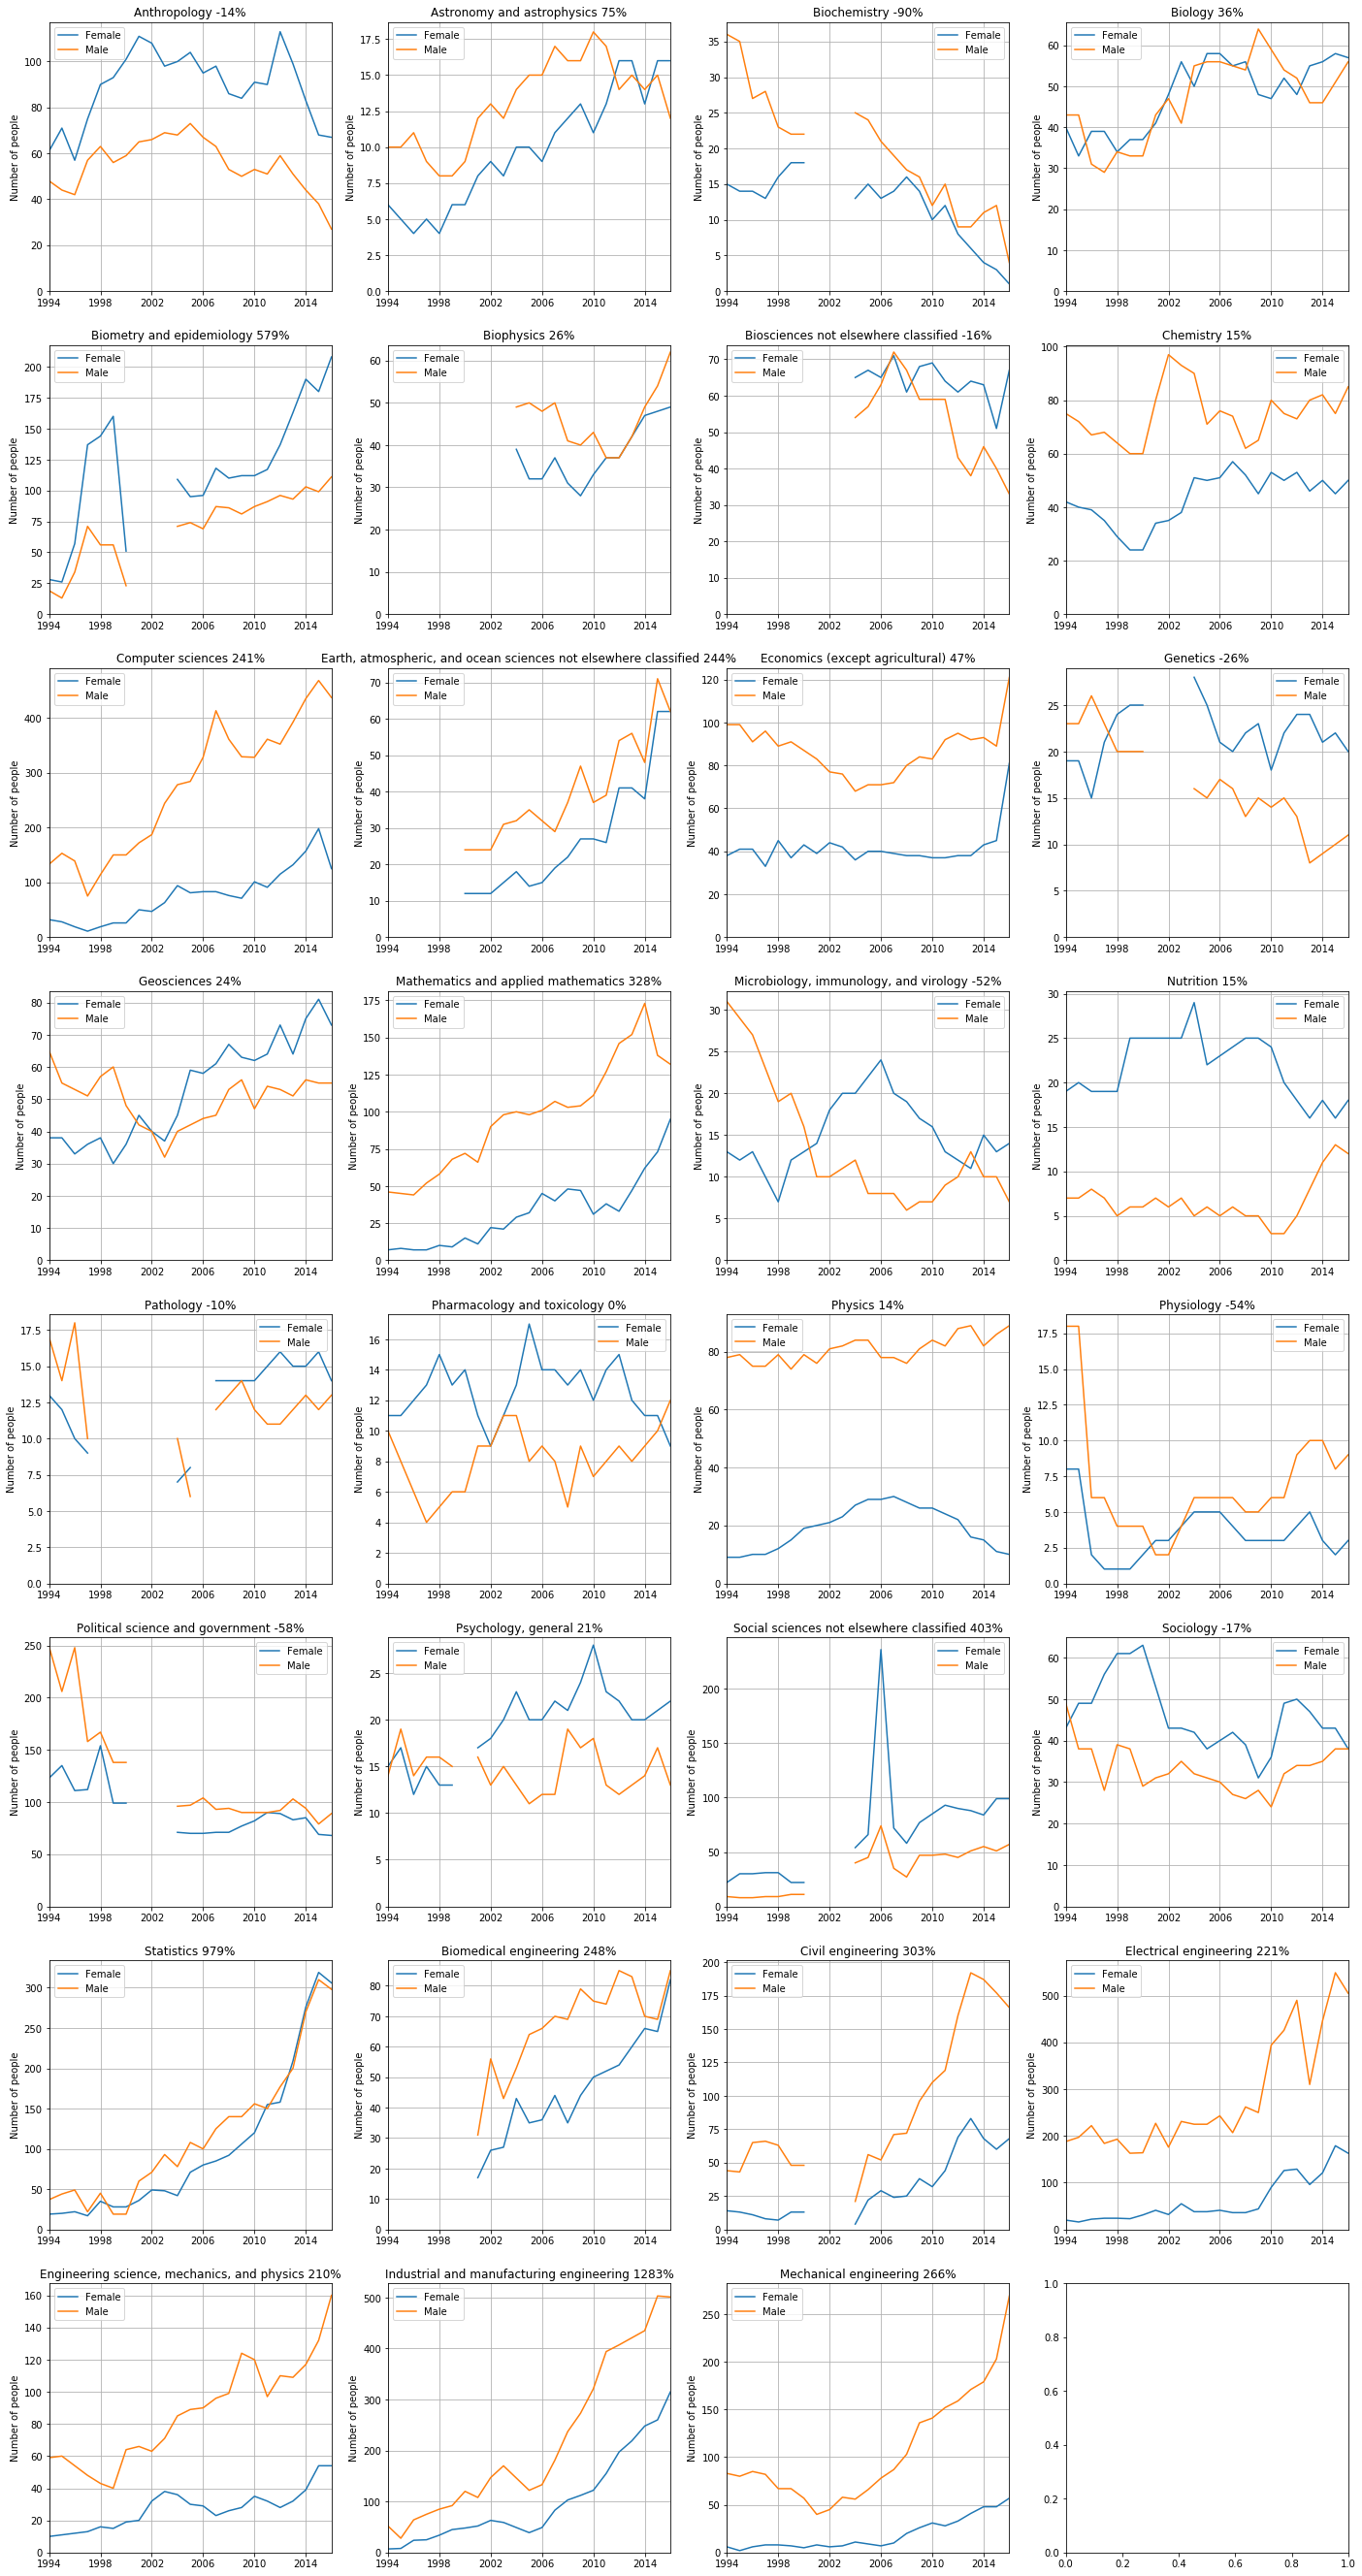

In [133]:
plot_fields_counts(
    [f for f in fields['Science'] + fields['Engineering'] if f not in sparse_fields],
    show_pcts=True
)

### Notes

### Imputation
GSS is not imputing the data for years when Columbia does not report the numbers for a certain field, effectively filling in holes with 0.

### Regarding empty fields in Engineering
* According to the [post-2010 mapping of instructional programs to GSS fields](https://ncsesdata.nsf.gov/gradpostdoc/2016/html/GSS2016_TTA_16.html), Earth and Environmental Engineering is grouped into Civil Engineering. The New York Post has it that Columbia [replaced its mining engineering program](https://nypost.com/2013/08/25/magnates-missing-millions-columbia-university-mining-program-runs-dry/) with Earth and Environmental Engineering. This matches the disappearance of Mining Engineering data after 1999. Moreover, in [SEAS' past bulletins (available since 2005)](https://bulletin.engineering.columbia.edu/previous-years-bulletins), Mining Engineering and Earth and Environmental Engineering are the two and only fields given the [HEGIS code](http://www.nysed.gov/college-university-evaluation/new-york-state-taxonomy-academic-programs-hegis-codes) 918.
* According to [NYS HEGIS codes](http://www.nysed.gov/college-university-evaluation/new-york-state-taxonomy-academic-programs-hegis-codes) and the [latest SEAS bulletin](https://bulletin.engineering.columbia.edu/files/seasbulletin/bulletin2012-2013.pdf) with registered programs and HEGIS codes (2012-13): the Engineering nec fields are "Combined Plan w/Affiliated College; Dual B.S. (M.S.)/B.A." and Computer Engineering. But GSS classifies Computer Engineering as Electrical Engineering. We will consider Engineering nec to be 0 before 2014.
* Biomedical engineering was established in [2000](https://bme.columbia.edu/about-0), so it can be zero-ed before 2001.

Takeaways: Engineering nec can be considered 0 before 2014, Mining Engineering after 1999, and Biomedical Engineering before 2001. That leaves Chemical Engineering and Civil Engineering to be imputed.